# Visualization Setup

results.zip 처리 후 시퀀스/임베딩을 로드하고, collapse 분석용 지표와 시각화를 수행합니다.


In [1]:
import sys
from pathlib import Path

current_dir = Path('.').resolve()


In [2]:
import shutil
import zipfile
import zlib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from metrics_utils import (
    cosine_series_from_embeddings,
    compute_gc_content,
    calculate_shannon_entropy,
    compute_vendi_score,
)


In [3]:
RESULTS_ZIP = Path('results.zip')
RESULTS_DIR = Path('results')

if RESULTS_ZIP.exists():
    if RESULTS_DIR.exists():
        shutil.rmtree(RESULTS_DIR)
    with zipfile.ZipFile(RESULTS_ZIP, 'r') as zf:
        zf.extractall(RESULTS_DIR)
    RESULTS_ZIP.unlink()
    print('results.zip extracted and cleaned')
else:
    print('results.zip not found; using existing results directory')


results.zip not found; using existing results directory


In [4]:
# Load sequences
SEQ_DIR = RESULTS_DIR / 'sequences'
all_sequences = {}

if SEQ_DIR.exists():
    for model_dir in sorted([p for p in SEQ_DIR.iterdir() if p.is_dir()]):
        model_name = model_dir.name
        all_sequences[model_name] = {}
        for csv_file in sorted(model_dir.glob('*.csv')):
            gene_id = csv_file.stem
            df = pd.read_csv(csv_file, index_col=0)
            sequences_dict = {strategy: df.loc[strategy].tolist() for strategy in df.index}
            all_sequences[model_name][gene_id] = sequences_dict
    print('Sequences loaded:', list(all_sequences.keys()))
else:
    print('WARNING: sequences directory not found:', SEQ_DIR)


Sequences loaded: ['DNABERT-2', 'NT-v2-500m', 'NT-v2-50m']


In [5]:
# Load embeddings
EMBEDDINGS_DIR = RESULTS_DIR / 'embeddings'
all_embeddings = {}

if EMBEDDINGS_DIR.exists():
    for pkl_file in sorted(EMBEDDINGS_DIR.glob('embeddings_*__by__*.pkl')):
        stem = pkl_file.stem
        name = stem.replace('embeddings_', '', 1)
        if '__by__' not in name:
            continue
        gen_label, eval_label = name.split('__by__', 1)
        with open(pkl_file, 'rb') as f:
            all_embeddings[(gen_label, eval_label)] = pickle.load(f)
    print('Embeddings loaded:', len(all_embeddings))
else:
    print('WARNING: embeddings directory not found:', EMBEDDINGS_DIR)

model_order = ['DNABERT-2', 'NT-v2-50m', 'NT-v2-500m']
self_embeddings = {k[0]: v for k, v in all_embeddings.items() if k[0] == k[1]}
self_embeddings_keys = [m for m in model_order if m in self_embeddings]
self_embeddings_keys += [m for m in self_embeddings.keys() if m not in self_embeddings_keys]
print('Self-eval models:', self_embeddings_keys)


Embeddings loaded: 9
Self-eval models: ['DNABERT-2', 'NT-v2-50m', 'NT-v2-500m']


## Step 2: Feature Engineering & Metric Extraction

Iteration/Model/Strategy/Gene 기준으로 시각화용 지표를 미리 계산합니다.


In [6]:
def sequence_complexity(seq):
    if not seq:
        return None
    raw = seq.encode('utf-8')
    return len(zlib.compress(raw)) / len(raw)

def safe_gc_percent(seq):
    if not seq:
        return None
    return compute_gc_content(seq) * 100.0

def build_metrics_df(all_sequences, self_embeddings, model_keys):
    records = []
    for model_label in model_keys:
        seqs_model = all_sequences.get(model_label, {})
        emb_model = self_embeddings.get(model_label, {})
        for gene_id, strategies in seqs_model.items():
            for strategy_key, seq_list in strategies.items():
                if not seq_list:
                    continue
                embs = emb_model.get(gene_id, {}).get(strategy_key, [])
                sims = cosine_series_from_embeddings(embs)
                seq0 = seq_list[0] if seq_list else ''
                gc0 = safe_gc_percent(seq0) if seq0 else None
                for idx, seq in enumerate(seq_list):
                    if not isinstance(seq, str) or not seq:
                        continue
                    gc = safe_gc_percent(seq)
                    entropy = calculate_shannon_entropy(seq)
                    complexity = sequence_complexity(seq)
                    sim = sims[idx] if idx < len(sims) else None
                    gc_delta = abs(gc - gc0) if gc is not None and gc0 is not None else None
                    records.append({
                        'Model': model_label,
                        'Strategy': strategy_key,
                        'Gene': gene_id,
                        'Iteration': idx,
                        'Similarity': sim,
                        'GC': gc,
                        'GC_Delta': gc_delta,
                        'Entropy': entropy,
                        'Complexity': complexity,
                        'Length': len(seq),
                    })
    return pd.DataFrame(records)

def build_vendi_df(self_embeddings, model_keys, max_samples=200, seed=7):
    rng = np.random.default_rng(seed)
    records = []
    for model_label in model_keys:
        emb_model = self_embeddings.get(model_label, {})
        per_strategy_iter = {}
        for gene_id, strategies in emb_model.items():
            for strategy_key, embs in strategies.items():
                for idx, emb in enumerate(embs):
                    if emb is None:
                        continue
                    per_strategy_iter.setdefault(strategy_key, {}).setdefault(idx, []).append(emb)
        for strategy_key, iter_map in per_strategy_iter.items():
            for idx, embs in iter_map.items():
                arr = np.asarray(embs)
                if arr.ndim == 1:
                    arr = arr.reshape(1, -1)
                if arr.shape[0] == 0:
                    continue
                if max_samples and arr.shape[0] > max_samples:
                    sample_idx = rng.choice(arr.shape[0], size=max_samples, replace=False)
                    arr = arr[sample_idx]
                vendi = compute_vendi_score(arr)
                records.append({
                    'Model': model_label,
                    'Strategy': strategy_key,
                    'Iteration': idx,
                    'Vendi': vendi,
                    'N': arr.shape[0],
                })
    return pd.DataFrame(records)

metrics_df = build_metrics_df(all_sequences, self_embeddings, self_embeddings_keys)
vendi_df = build_vendi_df(self_embeddings, self_embeddings_keys)
metrics_df.head()


,Model,Strategy,Gene,Iteration,Similarity,GC,GC_Delta,Entropy,Complexity,Length
0,DNABERT-2,greedy,GAPDH,0,1.000000,59.788575,0.000000,1.971221,0.313682,4919
1,DNABERT-2,greedy,GAPDH,1,0.986116,62.975930,3.187355,1.948151,0.311160,4570
2,DNABERT-2,greedy,GAPDH,2,0.951304,65.588167,5.799592,1.925239,0.306679,4327
3,DNABERT-2,greedy,GAPDH,3,0.930096,69.114786,9.326211,1.883897,0.301556,4112
4,DNABERT-2,greedy,GAPDH,4,0.901464,72.314366,12.525791,1.838625,0.294208,3919


## Step 3: Collapse across Decoding Strategies

Similarity(성능)와 Vendi(다양성)를 같은 축에서 비교해 전략별 균형점을 확인합니다.


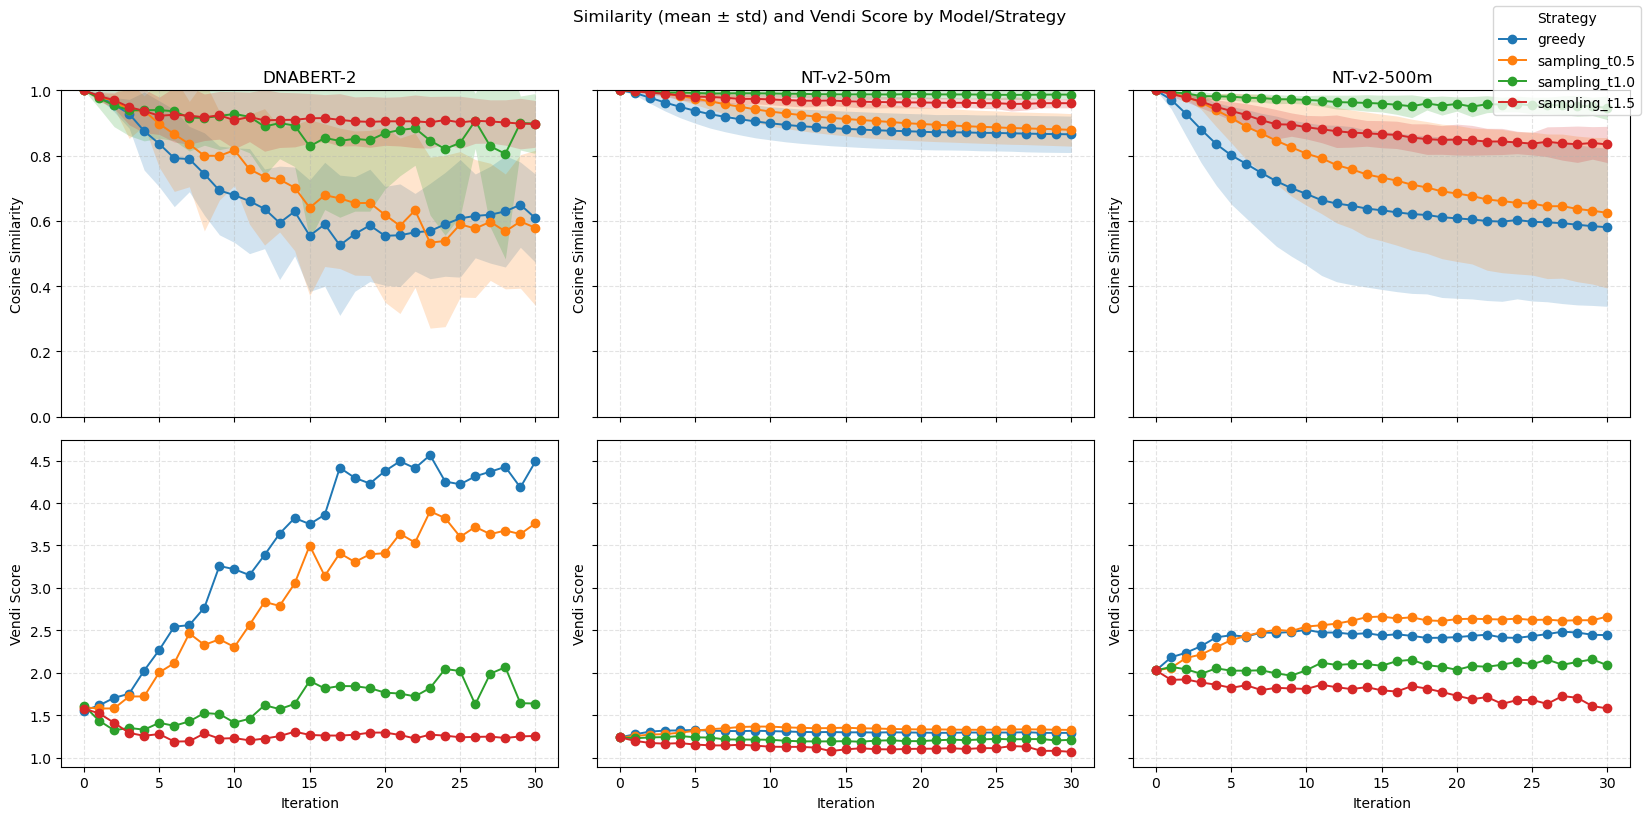

In [7]:
# Similarity (mean ± std) and Vendi Score split view
sim_summary = metrics_df.dropna(subset=['Similarity']).groupby(
    ['Model', 'Strategy', 'Iteration'], as_index=False
).agg(MeanSimilarity=('Similarity', 'mean'), StdSimilarity=('Similarity', 'std'))

vendi_summary = vendi_df.copy()

strategy_order = list(dict.fromkeys(sim_summary['Strategy'].tolist()))
palette = sns.color_palette('tab10', n_colors=max(1, len(strategy_order)))
strategy_colors = {s: palette[i % len(palette)] for i, s in enumerate(strategy_order)}

# Global y-limits for consistency
sim_ylim = (0.0, 1.0)
if not vendi_summary.empty:
    vmin = float(vendi_summary['Vendi'].min())
    vmax = float(vendi_summary['Vendi'].max())
    pad = 0.05 * (vmax - vmin) if vmax > vmin else 0.1
    vendi_ylim = (vmin - pad, vmax + pad)
else:
    vendi_ylim = (0.0, 1.0)

fig, axes = plt.subplots(2, 3, figsize=(16.5, 8.0), sharex=True, sharey='row')

for col_idx, model_label in enumerate(self_embeddings_keys):
    ax_top = axes[0, col_idx]
    ax_bot = axes[1, col_idx]

    sim_subset = sim_summary[sim_summary['Model'] == model_label]
    vendi_subset = vendi_summary[vendi_summary['Model'] == model_label]

    for strategy_key in strategy_order:
        df_s = sim_subset[sim_subset['Strategy'] == strategy_key]
        if df_s.empty:
            continue
        color = strategy_colors.get(strategy_key)
        ax_top.plot(
            df_s['Iteration'],
            df_s['MeanSimilarity'],
            marker='o',
            linewidth=1.4,
            color=color,
            label=strategy_key,
        )
        if df_s['StdSimilarity'].notna().any():
            ax_top.fill_between(
                df_s['Iteration'],
                df_s['MeanSimilarity'] - df_s['StdSimilarity'].fillna(0),
                df_s['MeanSimilarity'] + df_s['StdSimilarity'].fillna(0),
                color=color,
                alpha=0.2,
                linewidth=0,
            )

        df_v = vendi_subset[vendi_subset['Strategy'] == strategy_key]
        if df_v.empty:
            continue
        ax_bot.plot(
            df_v['Iteration'],
            df_v['Vendi'],
            marker='o',
            linewidth=1.4,
            color=color,
            label=strategy_key,
        )

    ax_top.set_title(model_label)
    ax_top.set_ylim(sim_ylim)
    ax_top.set_ylabel('Cosine Similarity')
    ax_top.grid(True, linestyle='--', alpha=0.35)

    ax_bot.set_ylim(vendi_ylim)
    ax_bot.set_ylabel('Vendi Score')
    ax_bot.set_xlabel('Iteration')
    ax_bot.grid(True, linestyle='--', alpha=0.35)

# Legend on the first column
handles, labels = axes[0, 0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, title='Strategy', loc='upper right', frameon=True)

fig.suptitle('Similarity (mean ± std) and Vendi Score by Model/Strategy', y=1.02)
fig.tight_layout()
plt.show()


### Similarity vs Vendi Trajectory (Iteration Path)

각 전략의 iteration 경로를 (Similarity, Vendi) 평면에서 연결해 collapse 경로를 확인합니다.


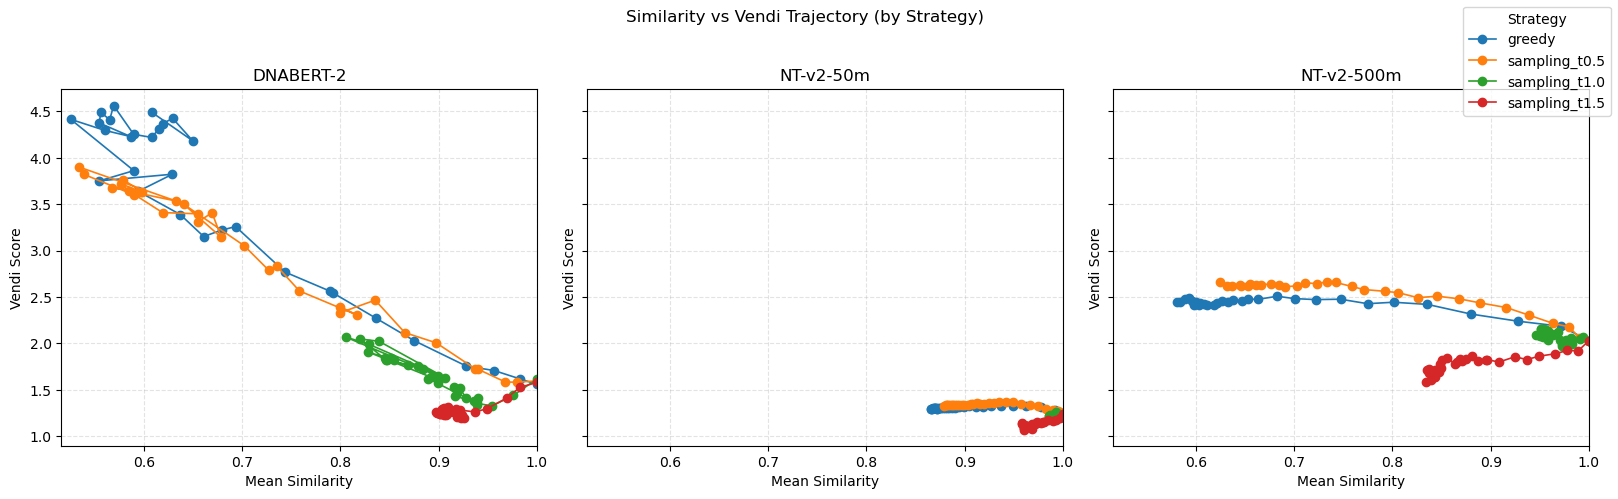

In [8]:
# Similarity vs Vendi trajectory (per model)
traj_df = sim_summary.merge(vendi_summary, on=['Model', 'Strategy', 'Iteration'], how='inner')

if traj_df.empty:
    print('WARNING: trajectory data is empty')
else:
    x_min = float(traj_df['MeanSimilarity'].min())
    x_max = float(traj_df['MeanSimilarity'].max())
    x_pad = 0.02 * (x_max - x_min) if x_max > x_min else 0.02
    x_lim = (max(0.0, x_min - x_pad), min(1.0, x_max + x_pad))

    y_min = float(traj_df['Vendi'].min())
    y_max = float(traj_df['Vendi'].max())
    y_pad = 0.05 * (y_max - y_min) if y_max > y_min else 0.1
    y_lim = (y_min - y_pad, y_max + y_pad)

    fig, axes = plt.subplots(1, 3, figsize=(16.2, 4.8), sharex=True, sharey=True)
    for idx, model_label in enumerate(self_embeddings_keys):
        ax = axes[idx]
        subset = traj_df[traj_df['Model'] == model_label]
        if subset.empty:
            ax.set_axis_off()
            continue
        for strategy_key in strategy_order:
            df_s = subset[subset['Strategy'] == strategy_key].sort_values('Iteration')
            if df_s.empty:
                continue
            color = strategy_colors.get(strategy_key)
            ax.plot(
                df_s['MeanSimilarity'],
                df_s['Vendi'],
                marker='o',
                linewidth=1.2,
                color=color,
                label=strategy_key,
            )
        ax.set_title(model_label)
        ax.set_xlabel('Mean Similarity')
        ax.set_ylabel('Vendi Score')
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.grid(True, linestyle='--', alpha=0.35)
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, title='Strategy', loc='upper right', frameon=True)
    fig.suptitle('Similarity vs Vendi Trajectory (by Strategy)', y=1.03)
    fig.tight_layout()
    plt.show()


**해석 가이드**
- Similarity는 유지되면서 Vendi가 0으로 떨어지지 않는 전략이 균형적입니다.
- Sampling t=1.0이 안정적으로 보존되면 이후 분석에서 기준 전략으로 사용합니다.


## Step 4: Collapse across Gene Properties (Sampling t=1.0)


In [9]:
STRATEGY_FOCUS = 'sampling_t1.0'
EXCLUDE_GENES = {'TTN'}

focus_df = metrics_df[metrics_df['Strategy'] == STRATEGY_FOCUS].copy()
focus_df = focus_df[~focus_df['Gene'].isin(EXCLUDE_GENES)]

init_df = focus_df[focus_df['Iteration'] == 0][['Model', 'Gene', 'GC', 'Length']].rename(
    columns={'GC': 'GC_Init', 'Length': 'Length_Init'}
)

slope_records = []
for (model_label, gene_id), group in focus_df.dropna(subset=['Similarity']).groupby(['Model', 'Gene']):
    if len(group) < 2:
        continue
    x = group['Iteration'].to_numpy(dtype=float)
    y = group['Similarity'].to_numpy(dtype=float)
    slope = float(np.polyfit(x, y, 1)[0])
    slope_records.append({
        'Model': model_label,
        'Gene': gene_id,
        'DecayRate': slope,
    })

slope_df = pd.DataFrame(slope_records)
slope_df = slope_df.merge(init_df, on=['Model', 'Gene'], how='left')


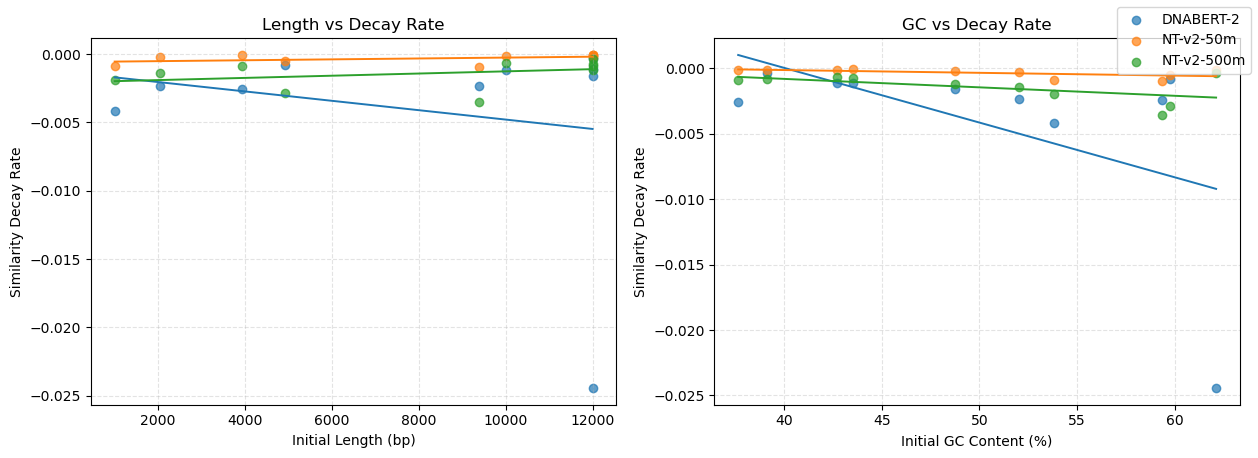

In [10]:
# Visualization 2: Length/GC vs Similarity Decay Rate
palette = sns.color_palette('tab10', n_colors=max(1, len(self_embeddings_keys)))
model_colors = {m: palette[i % len(palette)] for i, m in enumerate(self_embeddings_keys)}

fig, axes = plt.subplots(1, 2, figsize=(12.6, 4.6))
for model_label in self_embeddings_keys:
    subset = slope_df[slope_df['Model'] == model_label].dropna(subset=['Length_Init', 'GC_Init', 'DecayRate'])
    if subset.empty:
        continue
    color = model_colors.get(model_label)
    axes[0].scatter(subset['Length_Init'], subset['DecayRate'], color=color, alpha=0.7, label=model_label)
    if len(subset) > 1:
        xs = np.linspace(subset['Length_Init'].min(), subset['Length_Init'].max(), 100)
        coef = np.polyfit(subset['Length_Init'], subset['DecayRate'], 1)
        axes[0].plot(xs, np.polyval(coef, xs), color=color, linewidth=1.4)

    axes[1].scatter(subset['GC_Init'], subset['DecayRate'], color=color, alpha=0.7)
    if len(subset) > 1:
        xs = np.linspace(subset['GC_Init'].min(), subset['GC_Init'].max(), 100)
        coef = np.polyfit(subset['GC_Init'], subset['DecayRate'], 1)
        axes[1].plot(xs, np.polyval(coef, xs), color=color, linewidth=1.4)

axes[0].set_xlabel('Initial Length (bp)')
# axes[0].set_xscale('log')
axes[0].set_ylabel('Similarity Decay Rate')
axes[0].set_title('Length vs Decay Rate')
axes[0].grid(True, linestyle='--', alpha=0.35)

axes[1].set_xlabel('Initial GC Content (%)')
axes[1].set_ylabel('Similarity Decay Rate')
axes[1].set_title('GC vs Decay Rate')
axes[1].grid(True, linestyle='--', alpha=0.35)

handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc='upper right', frameon=True)
fig.tight_layout()
plt.show()


### Iteration Trajectories by Gene Length

Length bucket별 대표 gene을 골라 similarity/GC/entropy 변화를 모델별로 비교합니다.


Selected genes: ['SNHG1', 'GAPDH', 'TP53']


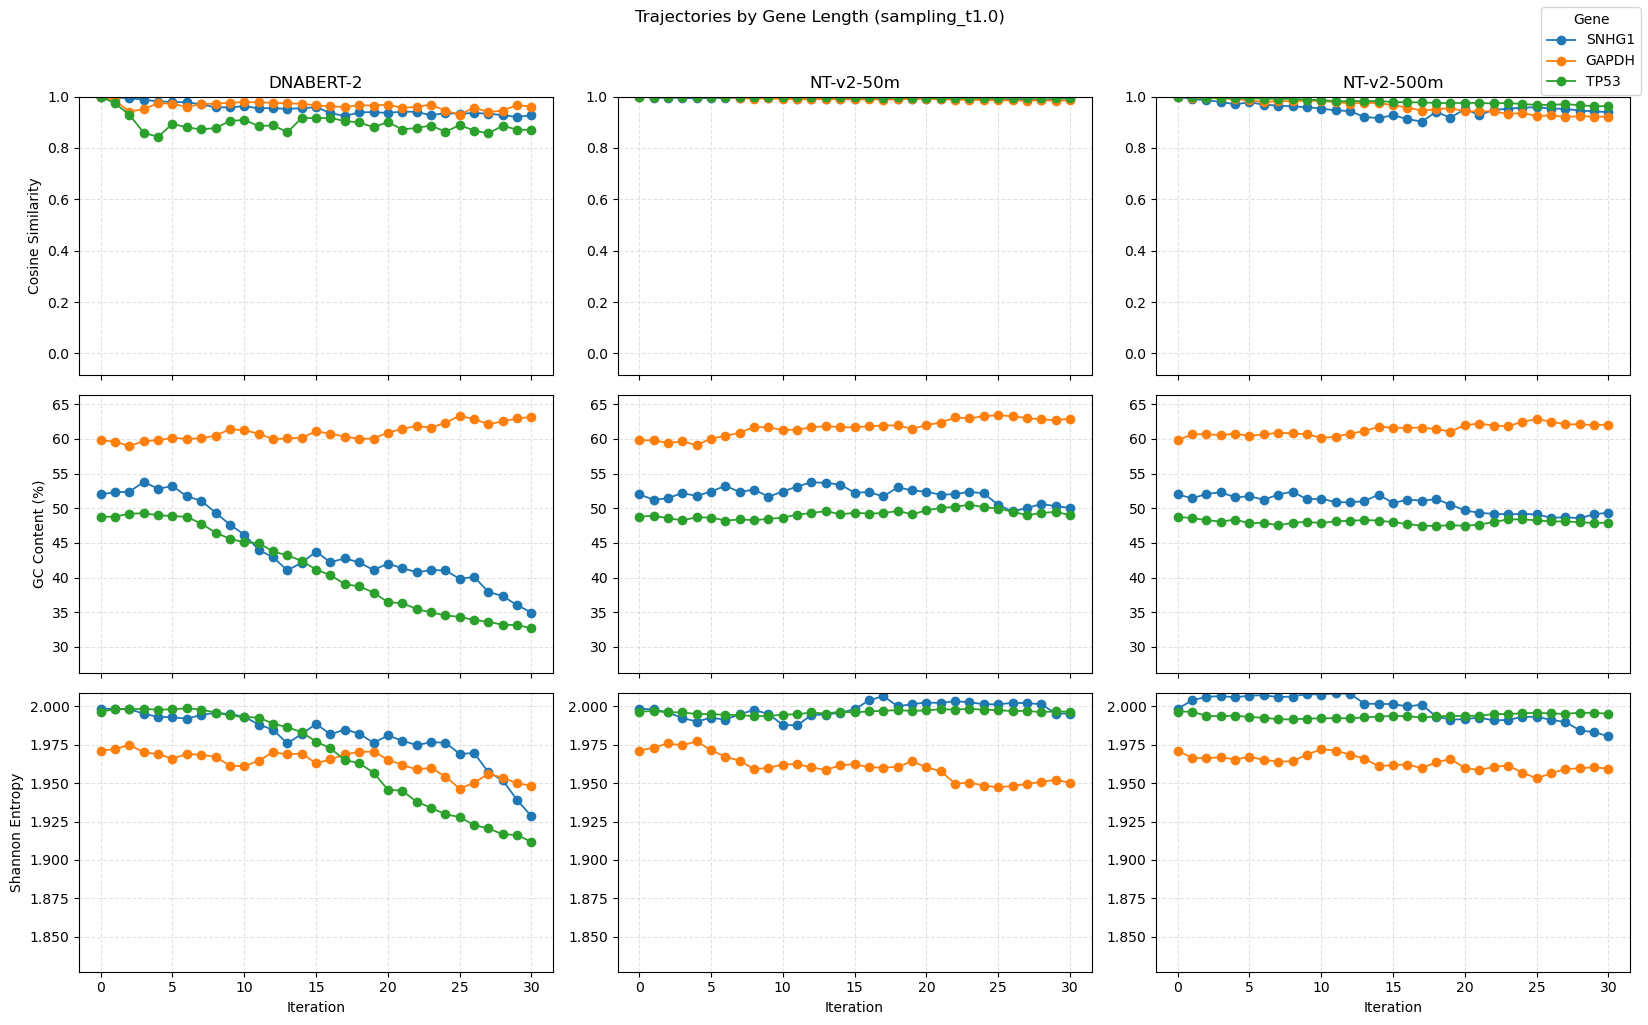

In [18]:
# Select representative genes by initial length (from focus_df)
def _pick_gene_by_length(init_df, min_len=None, max_len=None, target=None):
    subset = init_df.copy()
    if min_len is not None:
        subset = subset[subset['Length_Init'] >= min_len]
    if max_len is not None:
        subset = subset[subset['Length_Init'] <= max_len]
    if subset.empty:
        return None
    if target is None:
        return subset.sort_values('Length_Init').iloc[len(subset) // 2]['Gene']
    subset = subset.assign(dist=(subset['Length_Init'] - target).abs())
    return subset.sort_values('dist').iloc[0]['Gene']

init_df_local = init_df[['Gene', 'Length_Init']].drop_duplicates()
# short_gene = _pick_gene_by_length(init_df_local, max_len=2000, target=2000)
# mid_gene = _pick_gene_by_length(init_df_local, min_len=2000, max_len=5000, target=3500)
# long_gene = _pick_gene_by_length(init_df_local, min_len=10000, target=10000)

short_gene, mid_gene, long_gene = "SNHG1", "GAPDH", "TP53"

selected_genes = [g for g in [short_gene, mid_gene, long_gene] if g]
print('Selected genes:', selected_genes)

metric_rows = [
    ('Similarity', 'Cosine Similarity'),
    ('GC', 'GC Content (%)'),
    ('Entropy', 'Shannon Entropy'),
]

metric_limits = {}
for metric_key, _ in metric_rows:
    vals = focus_df[metric_key].dropna()
    if vals.empty:
        metric_limits[metric_key] = None
    else:
        metric_limits[metric_key] = (float(vals.min()), float(vals.max()))

fig, axes = plt.subplots(3, 3, figsize=(16.5, 10.0), sharex=True)
colors = sns.color_palette('tab10', n_colors=max(1, len(selected_genes)))
gene_colors = {g: colors[i % len(colors)] for i, g in enumerate(selected_genes)}

for col_idx, model_label in enumerate(self_embeddings_keys):
    model_df = focus_df[focus_df['Model'] == model_label]
    for row_idx, (metric_key, ylabel) in enumerate(metric_rows):
        ax = axes[row_idx, col_idx]
        for gene_id in selected_genes:
            subset = model_df[model_df['Gene'] == gene_id].sort_values('Iteration')
            if subset.empty:
                continue
            ax.plot(
                subset['Iteration'],
                subset[metric_key],
                marker='o',
                linewidth=1.3,
                color=gene_colors.get(gene_id),
                label=gene_id,
            )
        ax.grid(True, linestyle='--', alpha=0.35)
        limits = metric_limits.get(metric_key)
        if limits is not None:
            ax.set_ylim(limits)
        if row_idx == 0:
            ax.set_title(model_label)
        if col_idx == 0:
            ax.set_ylabel(ylabel)
        if row_idx == len(metric_rows) - 1:
            ax.set_xlabel('Iteration')

handles, labels = axes[0, 0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, title='Gene', loc='upper right', frameon=True)
fig.suptitle('Trajectories by Gene Length (sampling_t1.0)', y=1.02)
fig.tight_layout()
plt.show()


### Pairwise Trajectories (Matched Comparisons)

length/type가 맞는 coding vs non-coding 쌍과 real vs pseudogene 쌍을 각각 비교합니다.


Coding vs Non-coding pairs skipped (no explicit pairs).
Real vs Pseudogene pairs


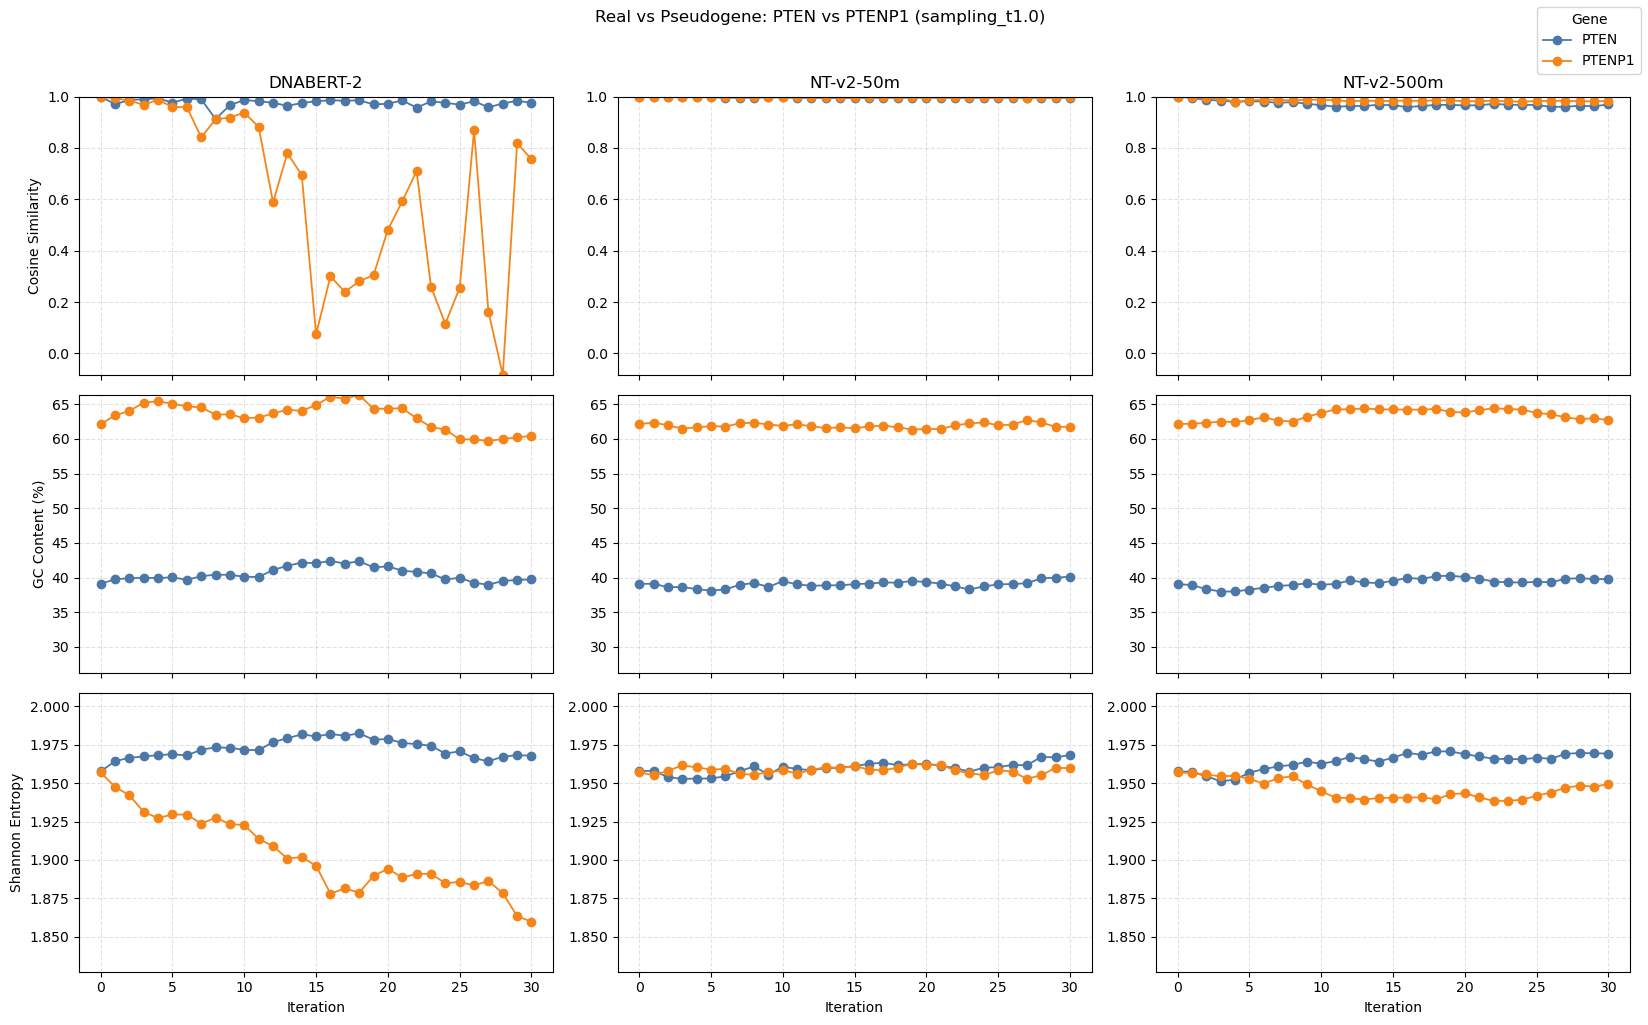

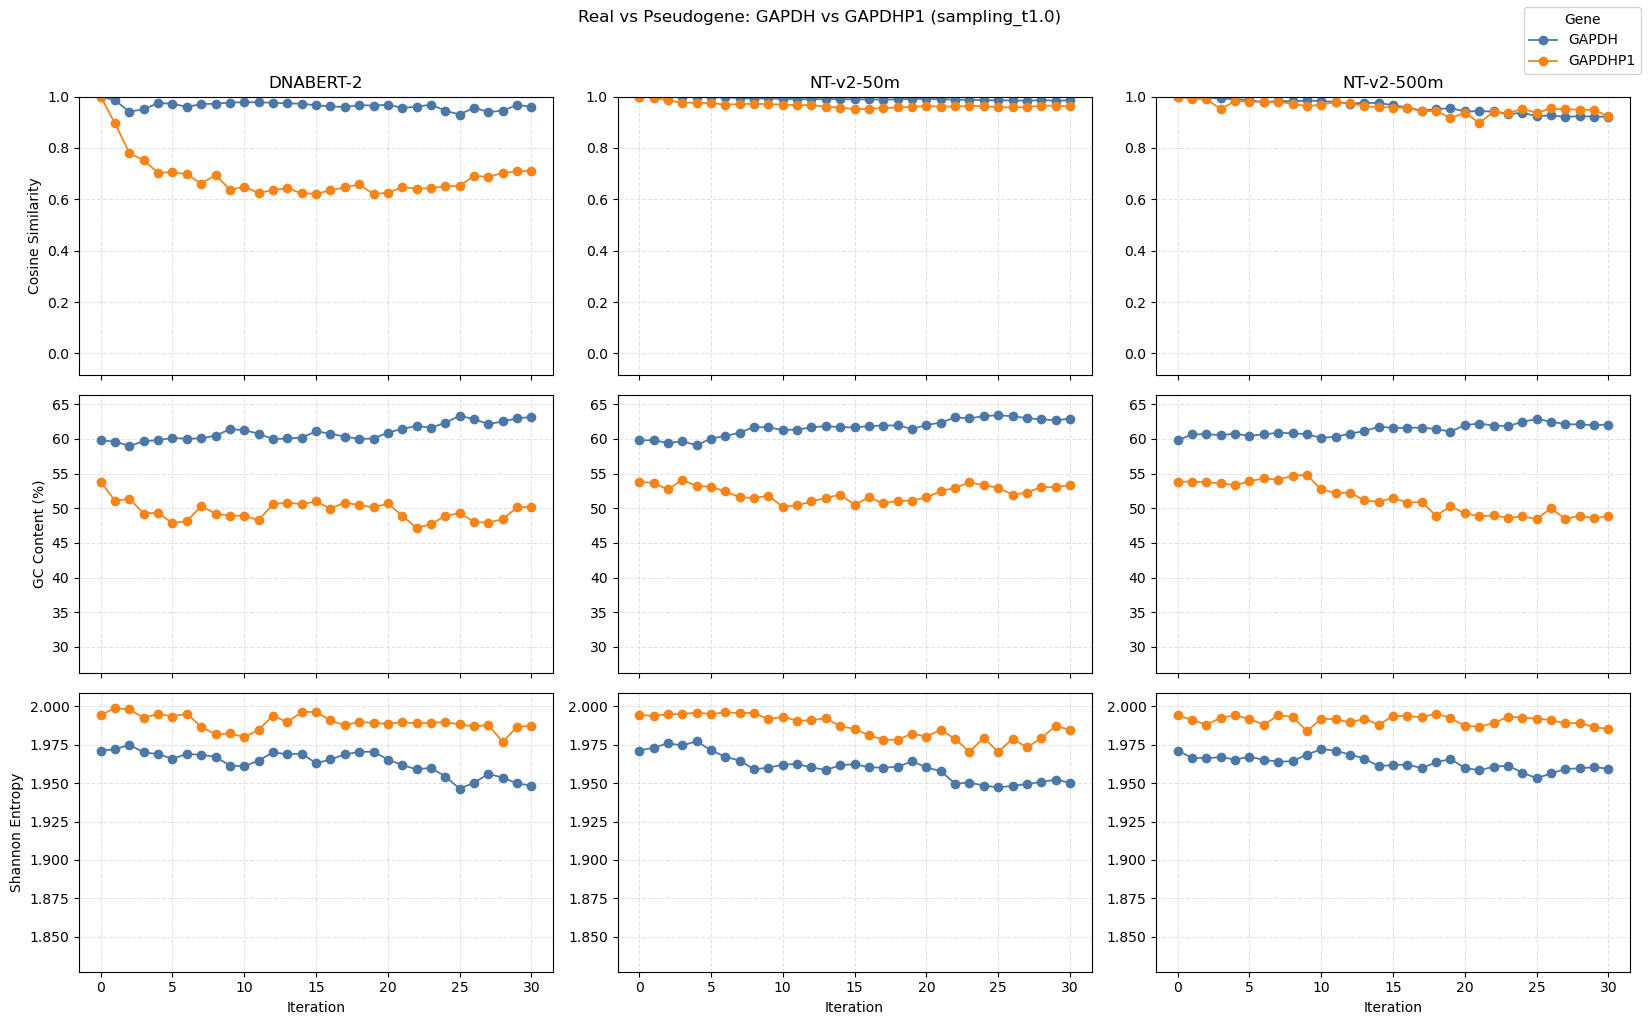

Coding vs Non-coding (mean +/- std)


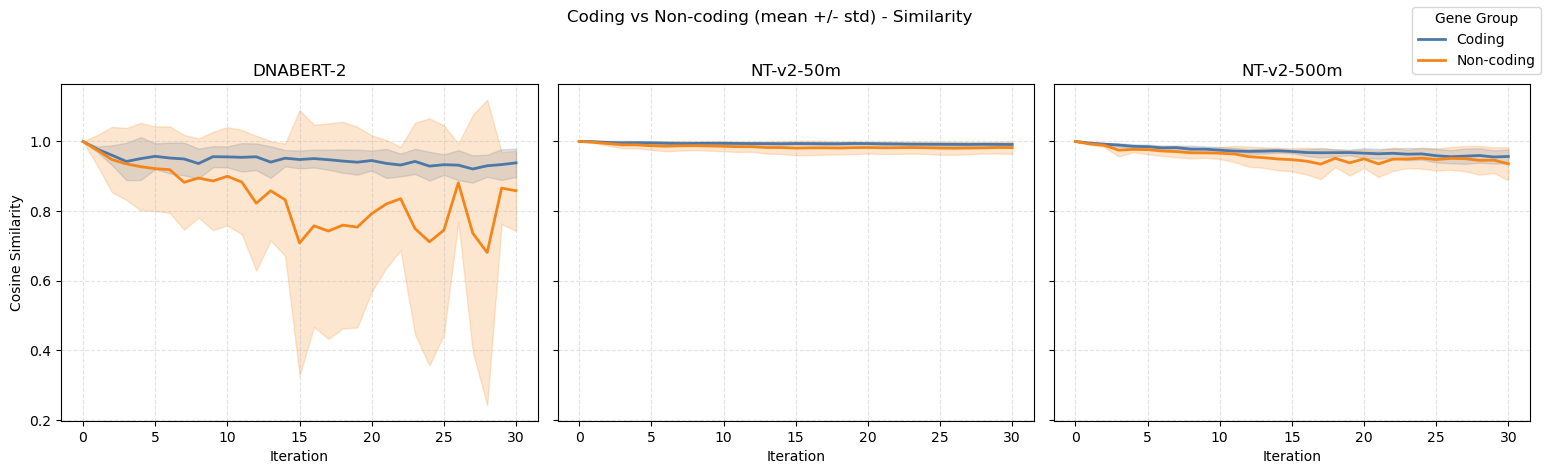

In [19]:
# coding_noncoding_pairs = [
#     ('HOXC11', 'HOTAIR'),
#     ('VEGFA', 'NEAT1'),
#     ('STAT3', 'NORAD'),
# ]
coding_genes = ["PTEN", "GAPDH", "HBB", "RPS29", "TP53"]
noncoding_genes = ['PTENP1', 'GAPDHP1', 'H19', 'GAS5', 'SNHG1']

real_pseudo_pairs = [
    ('PTEN', 'PTENP1'),
    ('GAPDH', 'GAPDHP1'),
]

metric_rows = [
    ('Similarity', 'Cosine Similarity'),
    ('GC', 'GC Content (%)'),
    ('Entropy', 'Shannon Entropy'),
]

metric_limits = {}
for metric_key, _ in metric_rows:
    vals = focus_df[metric_key].dropna()
    metric_limits[metric_key] = (float(vals.min()), float(vals.max())) if not vals.empty else None

def plot_pair_trajectories(pairs, title_prefix):
    for gene_a, gene_b in pairs:
        fig, axes = plt.subplots(3, 3, figsize=(16.5, 10.0), sharex=True)
        for col_idx, model_label in enumerate(self_embeddings_keys):
            model_df = focus_df[focus_df['Model'] == model_label]
            for row_idx, (metric_key, ylabel) in enumerate(metric_rows):
                ax = axes[row_idx, col_idx]
                for gene_id, color in [(gene_a, '#4C78A8'), (gene_b, '#F58518')]:
                    subset = model_df[model_df['Gene'] == gene_id].sort_values('Iteration')
                    if subset.empty:
                        continue
                    ax.plot(
                        subset['Iteration'],
                        subset[metric_key],
                        marker='o',
                        linewidth=1.3,
                        color=color,
                        label=gene_id,
                    )
                ax.grid(True, linestyle='--', alpha=0.35)
                limits = metric_limits.get(metric_key)
                if limits is not None:
                    ax.set_ylim(limits)
                if row_idx == 0:
                    ax.set_title(model_label)
                if col_idx == 0:
                    ax.set_ylabel(ylabel)
                if row_idx == len(metric_rows) - 1:
                    ax.set_xlabel('Iteration')
        handles, labels = axes[0, 0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, title='Gene', loc='upper right', frameon=True)
        fig.suptitle(f'{title_prefix}: {gene_a} vs {gene_b} (sampling_t1.0)', y=1.02)
        fig.tight_layout()
        plt.show()


def plot_group_similarity_mean_std():
    fig, axes = plt.subplots(1, 3, figsize=(15.5, 4.6), sharey=True)
    group_defs = [
        ("Coding", coding_genes, '#4C78A8'),
        ("Non-coding", noncoding_genes, '#F58518'),
    ]
    for col_idx, model_label in enumerate(self_embeddings_keys):
        ax = axes[col_idx]
        model_df = focus_df[focus_df['Model'] == model_label]
        for group_name, gene_list, color in group_defs:
            subset = model_df[model_df['Gene'].isin(gene_list)]
            if subset.empty:
                continue
            summary = (
                subset.groupby('Iteration')['Similarity']
                .agg(['mean', 'std'])
                .reset_index()
            )
            ax.plot(
                summary['Iteration'],
                summary['mean'],
                color=color,
                linewidth=2.0,
                label=group_name,
            )
            ax.fill_between(
                summary['Iteration'],
                summary['mean'] - summary['std'],
                summary['mean'] + summary['std'],
                color=color,
                alpha=0.2,
            )
        ax.grid(True, linestyle='--', alpha=0.35)
        ax.set_title(model_label)
        ax.set_xlabel('Iteration')
        if col_idx == 0:
            ax.set_ylabel('Cosine Similarity')
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, title='Gene Group', loc='upper right', frameon=True)
    fig.suptitle('Coding vs Non-coding (mean +/- std) - Similarity', y=1.02)
    fig.tight_layout()
    plt.show()

if 'coding_noncoding_pairs' in globals() and coding_noncoding_pairs:
    print('Coding vs Non-coding pairs')
    plot_pair_trajectories(coding_noncoding_pairs, 'Coding vs Non-coding')
else:
    print('Coding vs Non-coding pairs skipped (no explicit pairs).')

print('Real vs Pseudogene pairs')
plot_pair_trajectories(real_pseudo_pairs, 'Real vs Pseudogene')

print('Coding vs Non-coding (mean +/- std)')
plot_group_similarity_mean_std()


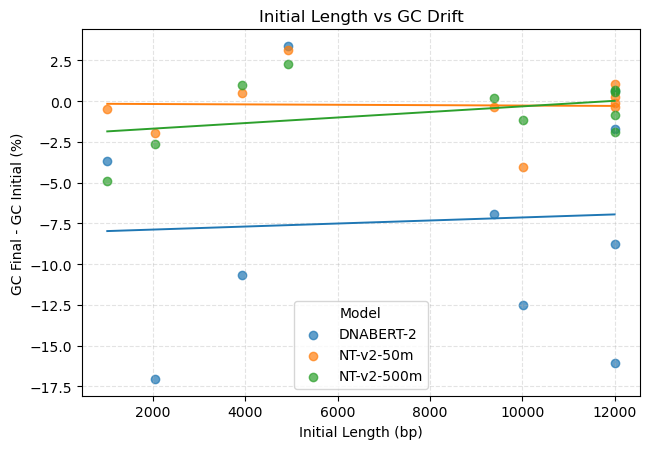

In [20]:
# Additional: Initial Length vs GC Drift
if 'gc_drift_df' in globals() and not gc_drift_df.empty:
    fig, ax = plt.subplots(figsize=(6.6, 4.6))
    for model_label in self_embeddings_keys:
        subset = gc_drift_df[gc_drift_df['Model'] == model_label].dropna(subset=['Length_Init', 'GC_Drift'])
        if subset.empty:
            continue
        color = model_colors.get(model_label) if 'model_colors' in globals() else None
        ax.scatter(subset['Length_Init'], subset['GC_Drift'], alpha=0.7, label=model_label, color=color)
        if len(subset) > 1:
            xs = np.linspace(subset['Length_Init'].min(), subset['Length_Init'].max(), 100)
            coef = np.polyfit(subset['Length_Init'], subset['GC_Drift'], 1)
            ax.plot(xs, np.polyval(coef, xs), color=color, linewidth=1.4)
    ax.set_title('Initial Length vs GC Drift')
    ax.set_xlabel('Initial Length (bp)')
    ax.set_ylabel('GC Final - GC Initial (%)')
    ax.grid(True, linestyle='--', alpha=0.35)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, title='Model')
    fig.tight_layout()
    plt.show()
else:
    print('WARNING: gc_drift_df not available for length vs GC drift plot')


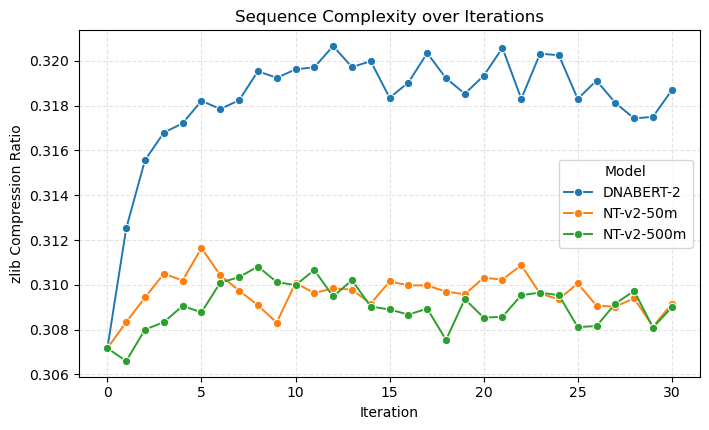

In [21]:
# Visualization 3: Structural Degradation (Complexity)
complexity_df = focus_df.dropna(subset=['Complexity']).groupby(
    ['Model', 'Iteration'], as_index=False
).agg({'Complexity': 'mean'})

fig, ax = plt.subplots(figsize=(7.2, 4.4))
sns.lineplot(
    data=complexity_df,
    x='Iteration',
    y='Complexity',
    hue='Model',
    hue_order=self_embeddings_keys,
    marker='o',
    linewidth=1.4,
    ax=ax,
)
ax.set_title('Sequence Complexity over Iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('zlib Compression Ratio')
ax.grid(True, linestyle='--', alpha=0.35)
ax.legend(title='Model')
fig.tight_layout()
plt.show()


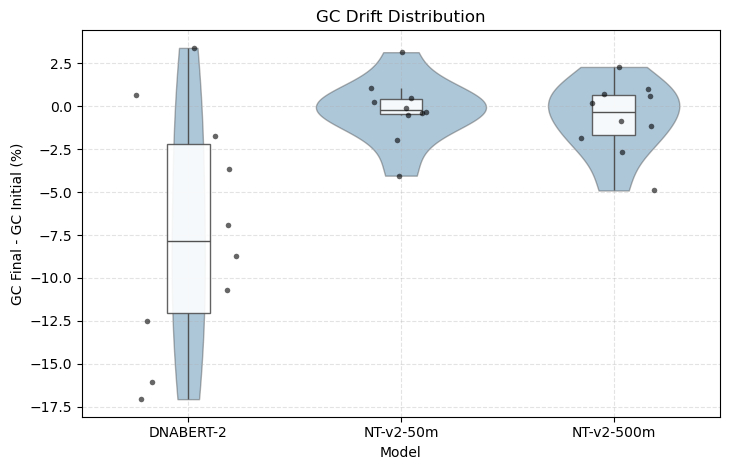

In [22]:
# Visualization 4: GC Drift Distribution (Raincloud)
final_df = focus_df.sort_values('Iteration').groupby(['Model', 'Gene'], as_index=False).tail(1)
final_df = final_df[['Model', 'Gene', 'GC']].rename(columns={'GC': 'GC_Final'})
gc_drift_df = init_df.merge(final_df, on=['Model', 'Gene'], how='inner')
gc_drift_df['GC_Drift'] = gc_drift_df['GC_Final'] - gc_drift_df['GC_Init']

fig, ax = plt.subplots(figsize=(7.4, 4.8))
sns.violinplot(
    data=gc_drift_df,
    x='Model',
    y='GC_Drift',
    order=self_embeddings_keys,
    inner=None,
    cut=0,
    linewidth=1.0,
    alpha=0.4,
    ax=ax,
)
sns.boxplot(
    data=gc_drift_df,
    x='Model',
    y='GC_Drift',
    order=self_embeddings_keys,
    width=0.2,
    showcaps=False,
    boxprops={'facecolor': 'white', 'alpha': 0.9},
    showfliers=False,
    whiskerprops={'linewidth': 1.0},
    ax=ax,
)
sns.stripplot(
    data=gc_drift_df,
    x='Model',
    y='GC_Drift',
    order=self_embeddings_keys,
    color='black',
    alpha=0.6,
    size=4,
    jitter=0.25,
    ax=ax,
)
ax.set_title('GC Drift Distribution')
ax.set_xlabel('Model')
ax.set_ylabel('GC Final - GC Initial (%)')
ax.grid(True, linestyle='--', alpha=0.35)
fig.tight_layout()
plt.show()


**해석 가이드**
- DecayRate가 더 음수일수록 빠르게 붕괴합니다.
- Complexity가 감소하면 단순 반복 구조로 붕괴하는 경향입니다.
- GC Drift 분포가 한쪽으로 치우치면 GC bias 가능성이 있습니다.


### Gene Type/Status Collapse (Final Iteration)

Sampling t=1.0 기준으로 최종 iteration의 similarity decay 분포를 비교합니다.


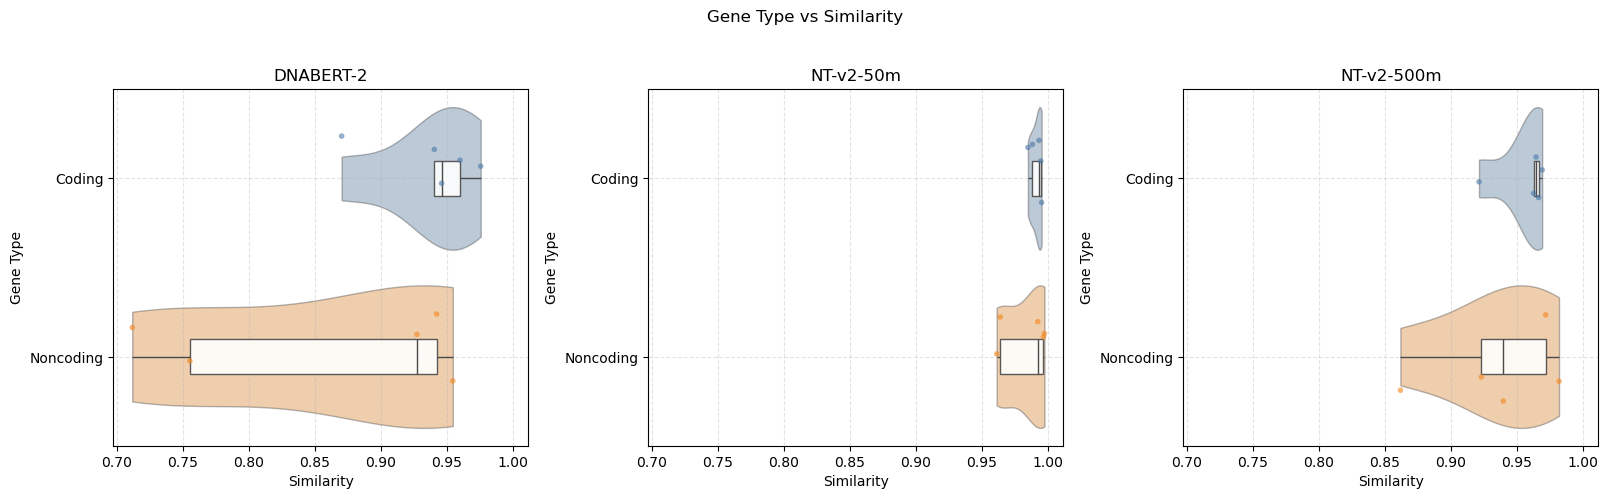

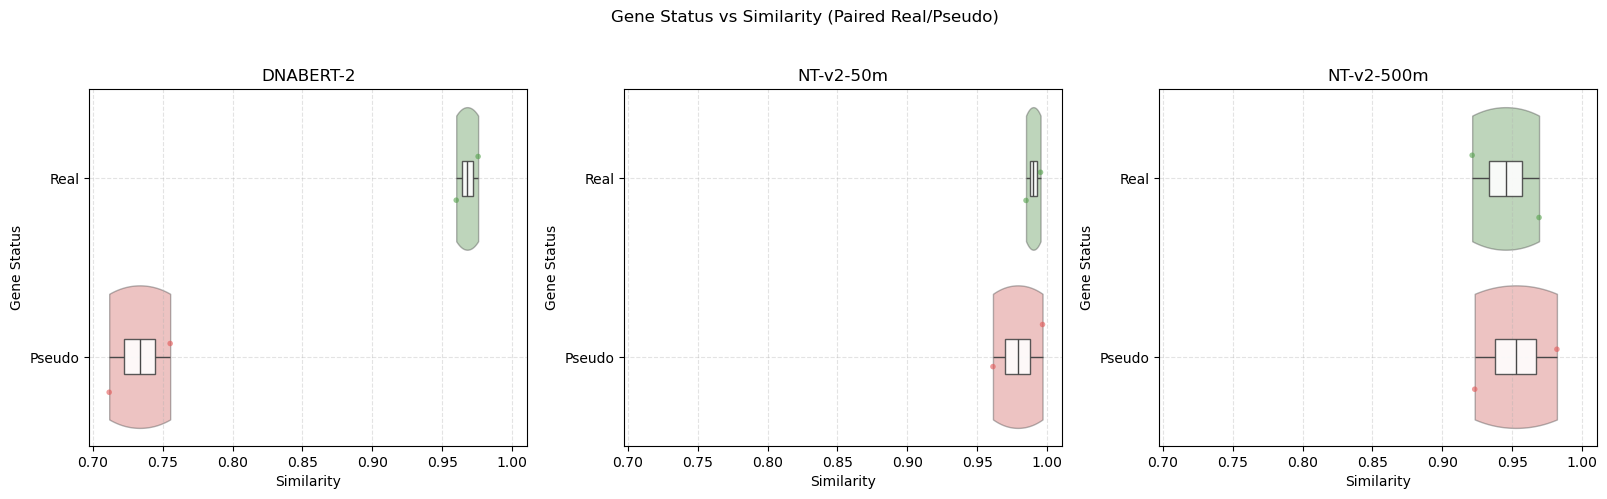

In [23]:
from idr.preparation import DEFAULT_GENES

gene_type_map = {gene: meta.get('type') for gene, meta in DEFAULT_GENES.items()}
gene_status_map = {gene: meta.get('status') for gene, meta in DEFAULT_GENES.items()}

# real-pseudogene pairs
paired_genes = [
    ('PTEN', 'PTENP1'),
    ('GAPDH', 'GAPDHP1'),
]
pair_map = {}
for idx, (real_gene, pseudo_gene) in enumerate(paired_genes):
    pair_map[real_gene] = idx
    pair_map[pseudo_gene] = idx

final_similarity_df = focus_df.dropna(subset=['Similarity']).sort_values('Iteration').groupby(
    ['Model', 'Gene'], as_index=False
).tail(1)[['Model', 'Gene', 'Similarity']]

type_df = final_similarity_df.copy()
type_df['GeneType'] = type_df['Gene'].map(gene_type_map)
type_df = type_df.dropna(subset=['GeneType'])

status_df = final_similarity_df.copy()
status_df['Status'] = status_df['Gene'].map(gene_status_map)
status_df['Pair'] = status_df['Gene'].map(pair_map)
status_df = status_df.dropna(subset=['Status', 'Pair'])

# keep only pairs that exist as real+pseudo within each model
pair_counts = status_df.groupby(['Model', 'Pair'])['Status'].nunique().reset_index()
valid_pairs = pair_counts[pair_counts['Status'] >= 2][['Model', 'Pair']]
status_df = status_df.merge(valid_pairs, on=['Model', 'Pair'], how='inner')

# Gene Type raincloud (horizontal)
type_palette = {'Coding': '#4C78A8', 'Noncoding': '#F58518'}
status_palette = {'Real': '#54A24B', 'Pseudo': '#E45756'}
fig, axes = plt.subplots(1, 3, figsize=(16.2, 4.8), sharex=True)
for idx, model_label in enumerate(self_embeddings_keys):
    ax = axes[idx]
    subset = type_df[type_df['Model'] == model_label]
    if subset.empty:
        ax.set_axis_off()
        continue
    sns.violinplot(
        data=subset,
        y='GeneType',
        x='Similarity',
        order=['Coding', 'Noncoding'],
        hue='GeneType',
        palette=type_palette,
        inner=None,
        cut=0,
        linewidth=1.0,
        alpha=0.4,
        ax=ax,
    )
    sns.boxplot(
        data=subset,
        y='GeneType',
        x='Similarity',
        order=['Coding', 'Noncoding'],
        hue='GeneType',
        palette=type_palette,
        width=0.2,
        showcaps=False,
        boxprops={'facecolor': 'white', 'alpha': 0.9},
        showfliers=False,
        whiskerprops={'linewidth': 1.0},
        ax=ax,
    )
    sns.stripplot(
        data=subset,
        y='GeneType',
        x='Similarity',
        order=['Coding', 'Noncoding'],
        hue='GeneType',
        palette=type_palette,
        color='black',
        alpha=0.6,
        size=4,
        jitter=0.25,
        ax=ax,
    )
    ax.set_title(model_label)
    ax.set_xlabel('Similarity')
    ax.set_ylabel('Gene Type')
    ax.grid(True, linestyle='--', alpha=0.35)
    if ax.get_legend() is not None:
        ax.get_legend().remove()
fig.suptitle('Gene Type vs Similarity', y=1.03)
fig.tight_layout()
plt.show()

# Gene Status raincloud (paired, horizontal)
fig, axes = plt.subplots(1, 3, figsize=(16.2, 4.8), sharex=True)
for idx, model_label in enumerate(self_embeddings_keys):
    ax = axes[idx]
    subset = status_df[status_df['Model'] == model_label]
    if subset.empty:
        ax.set_axis_off()
        continue
    sns.violinplot(
        data=subset,
        y='Status',
        x='Similarity',
        order=['Real', 'Pseudo'],
        hue='Status',
        palette=status_palette,
        inner=None,
        cut=0,
        linewidth=1.0,
        alpha=0.4,
        ax=ax,
    )
    sns.boxplot(
        data=subset,
        y='Status',
        x='Similarity',
        order=['Real', 'Pseudo'],
        hue='Status',
        palette=status_palette,
        width=0.2,
        showcaps=False,
        boxprops={'facecolor': 'white', 'alpha': 0.9},
        showfliers=False,
        whiskerprops={'linewidth': 1.0},
        ax=ax,
    )
    sns.stripplot(
        data=subset,
        y='Status',
        x='Similarity',
        order=['Real', 'Pseudo'],
        hue='Status',
        palette=status_palette,
        color='black',
        alpha=0.6,
        size=4,
        jitter=0.25,
        ax=ax,
    )
    ax.set_title(model_label)
    ax.set_xlabel('Similarity')
    ax.set_ylabel('Gene Status')
    ax.grid(True, linestyle='--', alpha=0.35)
    if ax.get_legend() is not None:
        ax.get_legend().remove()
fig.suptitle('Gene Status vs Similarity (Paired Real/Pseudo)', y=1.03)
fig.tight_layout()
plt.show()


### Gene Type vs Similarity (Downsampled)

Coding/Non-coding 표본 수를 동일하게 맞춘 후 분포를 비교합니다.


In [25]:
# rng = np.random.default_rng(7)

# def downsample_group(df, group_col, value_col):
#     groups = df[group_col].dropna().unique()
#     if len(groups) < 2:
#         return df
#     sizes = {g: (df[group_col] == g).sum() for g in groups}
#     target = min(sizes.values())
#     parts = []
#     for g in groups:
#         subset = df[df[group_col] == g]
#         if len(subset) <= target:
#             parts.append(subset)
#         else:
#             idx = rng.choice(subset.index.to_numpy(), size=target, replace=False)
#             parts.append(subset.loc[idx])
#     return pd.concat(parts, ignore_index=True)

# type_palette = {'Coding': '#4C78A8', 'Non-coding': '#F58518'}

# fig, axes = plt.subplots(1, 3, figsize=(16.2, 4.8), sharex=True)
# for idx, model_label in enumerate(self_embeddings_keys):
#     ax = axes[idx]
#     subset = type_df[type_df['Model'] == model_label]
#     subset = downsample_group(subset, 'GeneType', 'Similarity')
#     if subset.empty:
#         ax.set_axis_off()
#         continue
#     sns.violinplot(
#         data=subset,
#         y='GeneType',
#         x='Similarity',
#         order=['Coding', 'Non-coding'],
#         hue='GeneType',
#         palette=type_palette,
#         inner=None,
#         cut=0,
#         linewidth=1.0,
#         alpha=0.4,
#         ax=ax,
#     )
#     sns.boxplot(
#         data=subset,
#         y='GeneType',
#         x='Similarity',
#         order=['Coding', 'Non-coding'],
#         width=0.2,
#         showcaps=False,
#         boxprops={'facecolor': 'white', 'alpha': 0.9},
#         showfliers=False,
#         whiskerprops={'linewidth': 1.0},
#         palette=type_palette,
#         ax=ax,
#     )
#     sns.stripplot(
#         data=subset,
#         y='GeneType',
#         x='Similarity',
#         order=['Coding', 'Non-coding'],
#         hue='GeneType',
#         palette=type_palette,
#         alpha=0.6,
#         size=4,
#         jitter=0.25,
#         ax=ax,
#     )
#     ax.set_title(model_label)
#     ax.set_xlabel('Similarity')
#     ax.set_ylabel('Gene Type')
#     ax.grid(True, linestyle='--', alpha=0.35)
#     if ax.get_legend() is not None:
#         ax.get_legend().remove()

# fig.suptitle('Gene Type vs Similarity (Downsampled)', y=1.03)
# fig.tight_layout()
# plt.show()


### Paired Real-Pseudogene Difference (Real - Pseudo)

실제 유전자와 대응되는 pseudogene의 최종 similarity 차이를 직접 비교합니다.


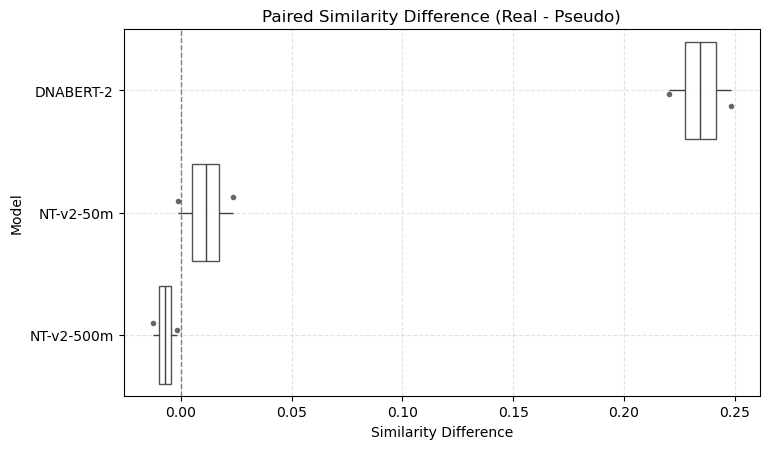

In [26]:
# Paired difference plot
pairs = paired_genes
pair_lookup = {p: idx for idx, p in enumerate(pairs)}

pair_records = []
for model_label in self_embeddings_keys:
    sub = final_similarity_df[final_similarity_df['Model'] == model_label]
    sim_map = {row.Gene: row.Similarity for row in sub.itertuples()}
    for pair_idx, (real_gene, pseudo_gene) in enumerate(pairs):
        if real_gene not in sim_map or pseudo_gene not in sim_map:
            continue
        diff = sim_map[real_gene] - sim_map[pseudo_gene]
        pair_records.append({
            'Model': model_label,
            'Pair': f'{real_gene}/{pseudo_gene}',
            'Diff': diff,
        })

pair_df = pd.DataFrame(pair_records)

fig, ax = plt.subplots(figsize=(7.8, 4.6))
sns.boxplot(
    data=pair_df,
    x='Diff',
    y='Model',
    order=self_embeddings_keys,
    showcaps=False,
    boxprops={'facecolor': 'white', 'alpha': 0.9},
    showfliers=False,
    whiskerprops={'linewidth': 1.0},
    ax=ax,
)
sns.stripplot(
    data=pair_df,
    x='Diff',
    y='Model',
    order=self_embeddings_keys,
    color='black',
    alpha=0.6,
    size=4,
    jitter=0.15,
    ax=ax,
)
ax.axvline(0, color='gray', linestyle='--', linewidth=1.0)
ax.set_title('Paired Similarity Difference (Real - Pseudo)')
ax.set_xlabel('Similarity Difference')
ax.set_ylabel('Model')
ax.grid(True, linestyle='--', alpha=0.35)
fig.tight_layout()
plt.show()


**해석 가이드**
- Coding/Non-coding 간 decay 분포 차이가 크면 gene type 편향이 존재합니다.
- Real/Pseudogene는 짝(pair) 비교만 포함하므로 길이/서열 유사성 통제 비교로 해석됩니다.


## Step 5: Cross-Validation & Model Confidence


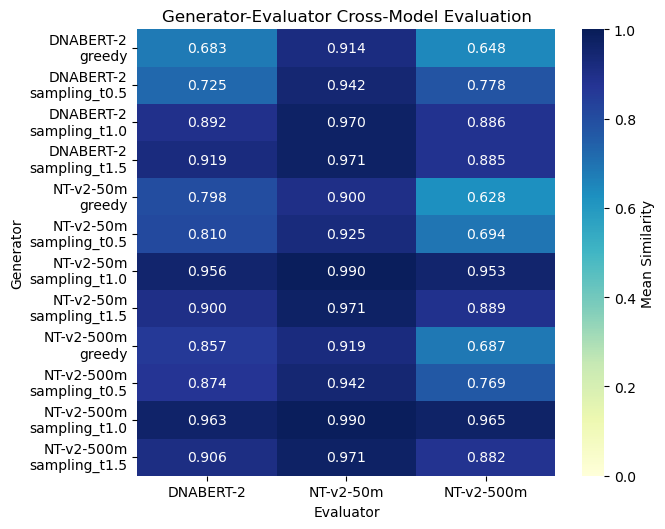

In [27]:
from visualization import plot_cross_validation_heatmap

evaluator_labels = self_embeddings_keys

base_model = self_embeddings_keys[0] if self_embeddings_keys else None
if base_model:
    first_gene = next(iter(self_embeddings[base_model].values()), {})
    strategy_order = list(first_gene.keys()) if first_gene else []
else:
    strategy_order = []

generator_labels = [
    (model_name, strategy_key)
    for model_name in self_embeddings_keys
    for strategy_key in strategy_order
]

if generator_labels:
    plot_cross_validation_heatmap(
        all_embeddings,
        generator_labels=generator_labels,
        evaluator_labels=self_embeddings_keys,
        iteration_range=(0, 50),
    )
else:
    print('WARNING: no generator labels for heatmap')


### Cross-Validation (Evaluator-Normalized)

Evaluator별 스케일 차이를 제거해 상대적 선호 패턴을 확인합니다.


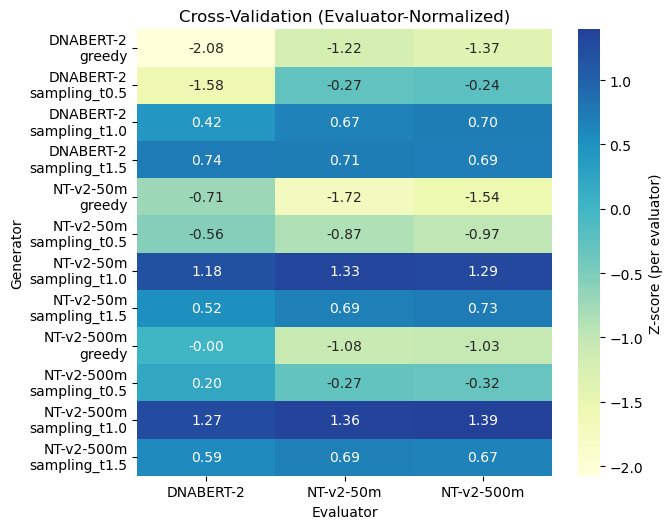

In [28]:
# Evaluator-normalized heatmap (z-score by column)
matrix = np.full((len(generator_labels), len(evaluator_labels)), np.nan)
for i, gen_label in enumerate(generator_labels):
    if isinstance(gen_label, (tuple, list)) and len(gen_label) == 2:
        gen_model, gen_strategy = gen_label
    else:
        gen_model = gen_label
        gen_strategy = None
    for j, eval_label in enumerate(evaluator_labels):
        emb_map = all_embeddings.get((gen_model, eval_label))
        if not emb_map:
            continue
        values = []
        for gene_id, strategies in emb_map.items():
            if gen_strategy is None:
                strategy_items = strategies.items()
            else:
                strategy_items = [(gen_strategy, strategies.get(gen_strategy, []))]
            for _, embs in strategy_items:
                sims = cosine_series_from_embeddings(embs)
                if not sims:
                    continue
                start, end = (0, 50)
                start = max(start, 0)
                end = min(end, len(sims) - 1)
                if start > end:
                    continue
                values.append(float(np.mean(sims[start:end + 1])))
        if values:
            matrix[i, j] = float(np.mean(values))

# z-score per evaluator (column)
norm = matrix.copy()
for j in range(norm.shape[1]):
    col = norm[:, j]
    valid = ~np.isnan(col)
    if valid.sum() < 2:
        continue
    mean = float(np.mean(col[valid]))
    std = float(np.std(col[valid]))
    if std == 0:
        continue
    norm[valid, j] = (col[valid] - mean) / std

fig, ax = plt.subplots(figsize=(6.8, 5.4))
sns.heatmap(
    norm,
    annot=True,
    fmt='.2f',
    xticklabels=evaluator_labels,
    yticklabels=[str(label[0]) + '\n' + str(label[1]) if isinstance(label, (tuple, list)) else str(label)
                 for label in generator_labels],
    cmap='YlGnBu',
    center=0,
    cbar_kws={'label': 'Z-score (per evaluator)'},
    ax=ax,
)
ax.set_xlabel('Evaluator')
ax.set_ylabel('Generator')
ax.set_title('Cross-Validation (Evaluator-Normalized)')
fig.tight_layout()
plt.show()


### Cross-Validation (Evaluator-Normalized, sampling_t1.0 only)

sampling_t1.0만 필터링하여 평가자별 상대 선호를 확인합니다.


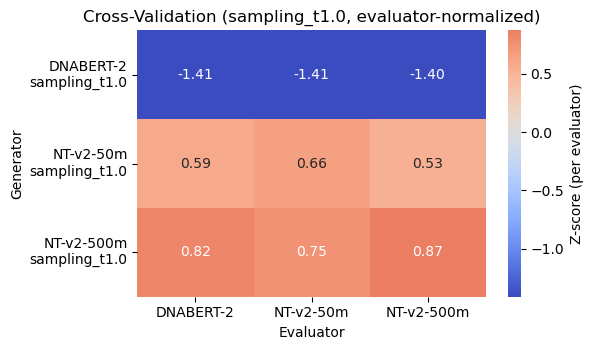

In [29]:
# Evaluator-normalized heatmap (sampling_t1.0 only)
target_strategy = 'sampling_t1.0'

filtered_generator_labels = [
    g for g in generator_labels
    if isinstance(g, (tuple, list)) and len(g) == 2 and g[1] == target_strategy
]

matrix = np.full((len(filtered_generator_labels), len(evaluator_labels)), np.nan)
for i, gen_label in enumerate(filtered_generator_labels):
    gen_model, gen_strategy = gen_label
    for j, eval_label in enumerate(evaluator_labels):
        emb_map = all_embeddings.get((gen_model, eval_label))
        if not emb_map:
            continue
        values = []
        for gene_id, strategies in emb_map.items():
            embs = strategies.get(gen_strategy, [])
            sims = cosine_series_from_embeddings(embs)
            if not sims:
                continue
            start, end = (0, 50)
            start = max(start, 0)
            end = min(end, len(sims) - 1)
            if start > end:
                continue
            values.append(float(np.mean(sims[start:end + 1])))
        if values:
            matrix[i, j] = float(np.mean(values))

# z-score per evaluator (column)
norm = matrix.copy()
for j in range(norm.shape[1]):
    col = norm[:, j]
    valid = ~np.isnan(col)
    if valid.sum() < 2:
        continue
    mean = float(np.mean(col[valid]))
    std = float(np.std(col[valid]))
    if std == 0:
        continue
    norm[valid, j] = (col[valid] - mean) / std

fig, ax = plt.subplots(figsize=(6.0, 3.6))
sns.heatmap(
    norm,
    annot=True,
    fmt='.2f',
    xticklabels=evaluator_labels,
    yticklabels=[str(label[0]) + '\n' + str(label[1]) for label in filtered_generator_labels],
    cmap='coolwarm',
    center=0,
    cbar_kws={'label': 'Z-score (per evaluator)'},
    ax=ax,
)
ax.set_xlabel('Evaluator')
ax.set_ylabel('Generator')
ax.set_title('Cross-Validation (sampling_t1.0, evaluator-normalized)')
fig.tight_layout()
plt.show()


### Self vs Cross Evaluation Tendency

각 generator에 대해 self-eval 점수와 다른 evaluator 평균 점수를 비교합니다.


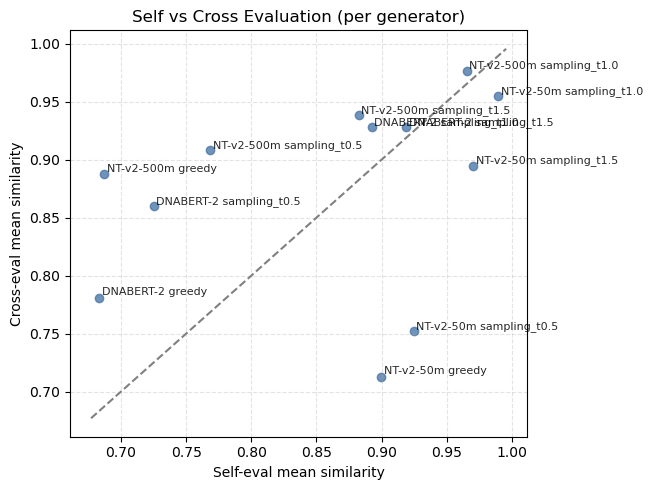

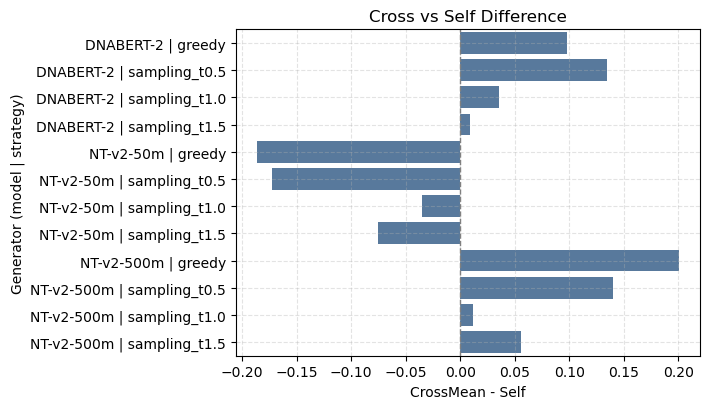

In [30]:
# Build cross-validation matrix (same logic as heatmap)
iteration_range = (0, 50)

matrix = np.full((len(generator_labels), len(evaluator_labels)), np.nan)
for i, gen_label in enumerate(generator_labels):
    if isinstance(gen_label, (tuple, list)) and len(gen_label) == 2:
        gen_model, gen_strategy = gen_label
    else:
        gen_model = gen_label
        gen_strategy = None
    for j, eval_label in enumerate(evaluator_labels):
        emb_map = all_embeddings.get((gen_model, eval_label))
        if not emb_map:
            continue
        values = []
        for gene_id, strategies in emb_map.items():
            if gen_strategy is None:
                strategy_items = strategies.items()
            else:
                strategy_items = [(gen_strategy, strategies.get(gen_strategy, []))]
            for _, embs in strategy_items:
                sims = cosine_series_from_embeddings(embs)
                if not sims:
                    continue
                start, end = iteration_range
                start = max(start, 0)
                end = min(end, len(sims) - 1)
                if start > end:
                    continue
                values.append(float(np.mean(sims[start:end + 1])))
        if values:
            matrix[i, j] = float(np.mean(values))

# Compare self-eval vs cross-eval mean
records = []
for i, gen_label in enumerate(generator_labels):
    if isinstance(gen_label, (tuple, list)) and len(gen_label) == 2:
        gen_model = gen_label[0]
        gen_label_text = str(gen_label[0]) + '\n' + str(gen_label[1])
    else:
        gen_model = gen_label
        gen_label_text = str(gen_label)
    if gen_model not in evaluator_labels:
        continue
    self_idx = evaluator_labels.index(gen_model)
    self_score = matrix[i, self_idx]
    if np.isnan(self_score):
        continue
    other_scores = [matrix[i, j] for j in range(len(evaluator_labels)) if j != self_idx]
    other_scores = [v for v in other_scores if not np.isnan(v)]
    if not other_scores:
        continue
    records.append({
        'Generator': gen_label_text,
        'Self': self_score,
        'CrossMean': float(np.mean(other_scores)),
    })

compare_df = pd.DataFrame(records)
compare_df['Label'] = compare_df['Generator'].str.replace('\n', ' ', regex=False)
compare_df['GeneratorLabel'] = compare_df['Generator'].str.replace('\n', ' | ', regex=False)

fig, ax = plt.subplots(figsize=(6.6, 5.0))
ax.scatter(compare_df['Self'], compare_df['CrossMean'], color='#4C78A8', alpha=0.8)
for _, row in compare_df.iterrows():
    ax.text(
        row['Self'] + 0.002,
        row['CrossMean'] + 0.002,
        row['Label'],
        fontsize=8,
        alpha=0.85,
    )
min_val = float(min(compare_df['Self'].min(), compare_df['CrossMean'].min()))
max_val = float(max(compare_df['Self'].max(), compare_df['CrossMean'].max()))
pad = 0.02 * (max_val - min_val) if max_val > min_val else 0.02
ax.plot([min_val - pad, max_val + pad], [min_val - pad, max_val + pad], linestyle='--', color='gray')
ax.set_xlabel('Self-eval mean similarity')
ax.set_ylabel('Cross-eval mean similarity')
ax.set_title('Self vs Cross Evaluation (per generator)')
ax.grid(True, linestyle='--', alpha=0.35)
fig.tight_layout()
plt.show()

# Difference plot (CrossMean - Self)
compare_df['Delta'] = compare_df['CrossMean'] - compare_df['Self']
fig, ax = plt.subplots(figsize=(7.2, 4.2))
sns.barplot(data=compare_df, x='Delta', y='GeneratorLabel', color='#4C78A8', ax=ax)
ax.axvline(0, color='gray', linestyle='--', linewidth=1.0)
ax.set_xlabel('CrossMean - Self')
ax.set_ylabel('Generator (model | strategy)')
ax.set_title('Cross vs Self Difference')
ax.grid(True, linestyle='--', alpha=0.35)
fig.tight_layout()
plt.show()


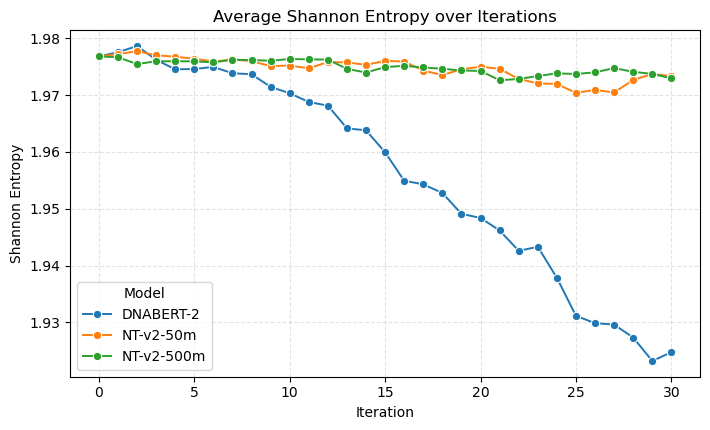

In [31]:
# Visualization 6: Model Confidence Trend (Entropy)
entropy_df = focus_df.dropna(subset=['Entropy']).groupby(
    ['Model', 'Iteration'], as_index=False
).agg({'Entropy': 'mean'})

fig, ax = plt.subplots(figsize=(7.2, 4.4))
sns.lineplot(
    data=entropy_df,
    x='Iteration',
    y='Entropy',
    hue='Model',
    hue_order=self_embeddings_keys,
    marker='o',
    linewidth=1.4,
    ax=ax,
)
ax.set_title('Average Shannon Entropy over Iterations')
ax.set_xlabel('Iteration')
ax.set_ylabel('Shannon Entropy')
ax.grid(True, linestyle='--', alpha=0.35)
ax.legend(title='Model')
fig.tight_layout()
plt.show()


**해석 가이드**
- Heatmap의 비대각선이 높으면 모델 간 표현이 호환적입니다.
- Entropy가 낮아지면 더 단순한 패턴으로 고착화되는 경향입니다.


## TODO

- Pseudogene reconstruction이 진행되면 real gene과 가까워지는지 확인하기 위해 PCA trajectory를 활용해볼 것.


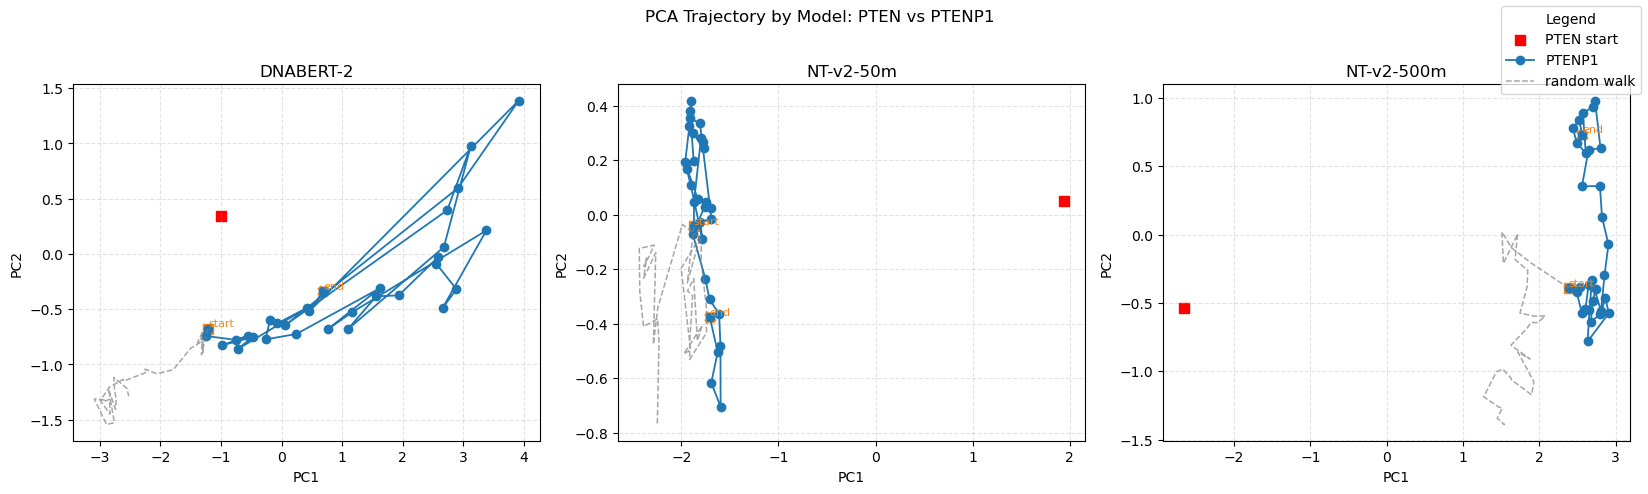

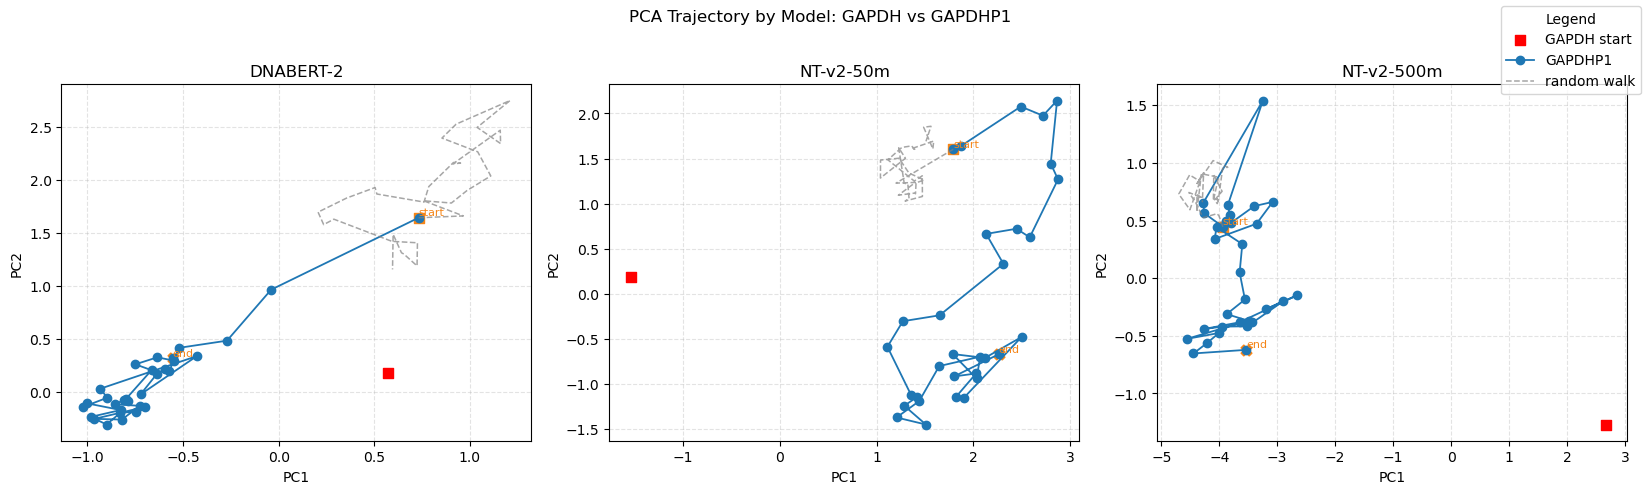

In [32]:
# PCA trajectory panel by model (per gene pair)
from sklearn.decomposition import PCA

rng = np.random.default_rng(7)

pairs_to_plot = [
    ('PTEN', 'PTENP1'),
    ('GAPDH', 'GAPDHP1'),
]

def _stack_embeddings(embs):
    flat = [np.ravel(e) for e in embs if e is not None]
    if not flat:
        return None
    return np.vstack(flat)

def _random_walk_2d(n_steps, scale=0.15):
    steps = rng.normal(loc=0.0, scale=scale, size=(n_steps, 2))
    return np.cumsum(steps, axis=0)

def plot_pair_pca_panel(gene_real, gene_pseudo, strategy='sampling_t1.0'):
    fig, axes = plt.subplots(1, 3, figsize=(16.5, 4.8), sharex=False, sharey=False)
    for col_idx, model_label in enumerate(self_embeddings_keys):
        ax = axes[col_idx]
        emb_model = self_embeddings.get(model_label, {})
        embs_real = emb_model.get(gene_real, {}).get(strategy, [])
        embs_pseudo = emb_model.get(gene_pseudo, {}).get(strategy, [])
        if not embs_real or not embs_pseudo:
            ax.set_axis_off()
            continue

        mat_real = _stack_embeddings(embs_real)
        mat_pseudo = _stack_embeddings(embs_pseudo)
        if mat_real is None or mat_pseudo is None:
            ax.set_axis_off()
            continue

        matrix = np.vstack([mat_real, mat_pseudo])
        if matrix.shape[0] < 2:
            ax.set_axis_off()
            continue

        pca = PCA(n_components=2)
        coords_all = pca.fit_transform(matrix)
        coords_real = coords_all[: len(mat_real)]
        coords_pseudo = coords_all[len(mat_real) :]

        # Real gene start
        real_start = coords_real[0]
        ax.scatter(real_start[0], real_start[1], marker='s', s=60, color='red', label=f'{gene_real} start')

        # Pseudogene trajectory
        ax.plot(coords_pseudo[:, 0], coords_pseudo[:, 1], marker='o', linewidth=1.3, label=gene_pseudo)
        ax.scatter(coords_pseudo[0, 0], coords_pseudo[0, 1], marker='s', s=55, color='#F58518')
        ax.text(coords_pseudo[0, 0], coords_pseudo[0, 1], 'start', fontsize=8, color='#F58518', va='bottom')
        ax.scatter(coords_pseudo[-1, 0], coords_pseudo[-1, 1], marker='X', s=60, color='#F58518')
        ax.text(coords_pseudo[-1, 0], coords_pseudo[-1, 1], 'end', fontsize=8, color='#F58518', va='bottom')

        # Random walk baseline starting at pseudogene start
        n_steps = coords_pseudo.shape[0]
        rw = _random_walk_2d(n_steps) + coords_pseudo[0]
        rw[0] = coords_pseudo[0]
        ax.plot(rw[:, 0], rw[:, 1], linestyle='--', linewidth=1.1, color='gray', alpha=0.7, label='random walk')

        ax.set_title(model_label)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.grid(True, linestyle='--', alpha=0.35)

    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, title='Legend', loc='upper right', frameon=True)
    fig.suptitle(f'PCA Trajectory by Model: {gene_real} vs {gene_pseudo}', y=1.02)
    fig.tight_layout()
    plt.show()

for real_gene, pseudo_gene in pairs_to_plot:
    plot_pair_pca_panel(real_gene, pseudo_gene)
